# Classification : Prédiction de la présence ou l’absence d’une maladie cardiovasculaire à partir de données médicales

# Introduction
Le présent rapport détaille la mise en œuvre d'une solution de Machine Learning visant à prédire la présence ou l'absence de maladies cardiovasculaires chez les patients. Cette problématique représente un enjeu de santé publique majeur, les maladies cardiovasculaires étant la première cause de mortalité mondiale.
Notre approche s'articule autour de quatre classifieurs dont nous comparerons rigoureusement les performances à travers diverses métriques d'évaluation. Ces classifieurs sont :
- Random Forest,
- Gradient Boosting,
- Decision Tree,
- Naive Bayes.

Nous évaluerons la performance avec plusieurs métriques : accuracy, F1-score, sensibilité, spécificité, matrice de confusion, courbe ROC et AUC.

NB : Nous avons essayé de laisser tourner les codes des modèles de classification pour espérer améliorer nos performances, mais mon ordinateur a planté. De ce fait, on a préféré laisser nos performances comme elles étaient.

## 1. Chargement et Exploration des Données

### a. Importation des bibliothèques

In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as p

### b. Chargement du dataset
Nous avons utilisé pour ce projet le dataset ou base de données « cardio_train.csv », une base de données médicale comprenant 70 000 patients et 12 variables explicatives :
- Variables démographiques : âge (`age` en jours), genre, taille et poids,
- Variables cliniques : pression artérielle systoliques (`ap_hi`) et diastolique (`ap_lo`), taux de cholestérol (`cholesterol`) et glucose sanguin (`gluc`),
- Variables comportementales : tabagisme (`smoke`), consommation d’alcool (alco) et activité physique (`active`),
- Variable cible ou target : présence (1) ou absence (0) de maladie cardiovasculaire (`cardio`).

In [2]:
df = pd.read_csv('cardio_train.csv', sep=';')

### c. Aperçu des données
On veut ici comprendre la structure, la qualité et la distribution des données. Pour ce faire, on affiche toutes les informations sur le dataset, les premières lignes, les statistiques descriptives des varaibles numériques, la distribution de la variable cible `cardio` et la visualisation de la distribution de cette varaible cible.


Premières lignes du dataset :
   id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   0  18393       2     168    62.0    110     80            1     1      0   
1   1  20228       1     156    85.0    140     90            3     1      0   
2   2  18857       1     165    64.0    130     70            3     1      0   
3   3  17623       2     169    82.0    150    100            1     1      0   
4   4  17474       1     156    56.0    100     60            1     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0  

Informations sur le dataset :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 

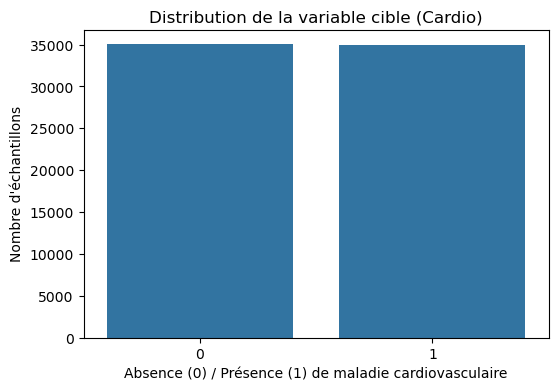

In [3]:
if df is not None:
    print("\nPremières lignes du dataset :")
    print(df.head())

    print("\nInformations sur le dataset :")
    print(df.info())

    print("\nStatistiques descriptives des variables numériques :")
    print(df.describe())

    print("\nDistribution de la variable cible 'cardio' :")
    print(df['cardio'].value_counts())

    plt.figure(figsize=(6, 4))
    sns.countplot(x='cardio', data=df)
    plt.title('Distribution de la variable cible (Cardio)')
    plt.xlabel('Absence (0) / Présence (1) de maladie cardiovasculaire')
    plt.ylabel('Nombre d\'échantillons')
    plt.show()

Pour la distribution des classes (0/1), on remarque qu'elle est quasi parfaitement équilibrée (50.03% vs 49.97%), évitant ainsi le problème classique de déséquilibre des classes.

## 2. Prétraitement initial

Nous allons vérifier s'il y'a des valeurs maleurs manquantes et les imputer, et aussi séparer les features et de la target.

In [4]:
if df is not None:
    # Vérification des valeurs manquantes
    print("\nNombre de valeurs manquantes par colonne :")
    print(df.isnull().sum())

    # Imputation des valeurs manquantes : Imputation par la moyenne pour les colonnes numériques
    for col in df.select_dtypes(include=np.number).columns:
        if df[col].isnull().any():
            mean_val = df[col].mean()
            df[col].fillna(mean_val, inplace=True)
            print(f"Valeurs manquantes dans '{col}' imputées avec la moyenne ({mean_val:.2f}).")

    # Imputation des valeurs manquantes : Imputation par le mode pour les colonnes catégorielles 
    for col in df.select_dtypes(include='object').columns: # Par contre dans mon dataset les catégorielles soient déjà numériques
        if df[col].isnull().any():
            mode_val = df[col].mode()[0]
            df[col].fillna(mode_val, inplace=True)
            print(f"Valeurs manquantes dans '{col}' imputées avec le mode ({mode_val}).")

    print("\nNombre de valeurs manquantes après imputation :")
    print(df.isnull().sum())
    
    # On sépare les features (X) et la target (y)
    X = df.drop('cardio', axis=1)
    y = df['cardio']

    print("\nFeatures (X) shape :", X.shape)
    print("Target (y) shape :", y.shape)


Nombre de valeurs manquantes par colonne :
id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

Nombre de valeurs manquantes après imputation :
id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

Features (X) shape : (70000, 12)
Target (y) shape : (70000,)


On remarque que notre dataset ne contient pas de valeurs manquantes.

### a. Analyse des données 
Ici on analyse les données pour observer les outliers et on affiche la matrice de corrélation pour nous aider à la sélection des features.

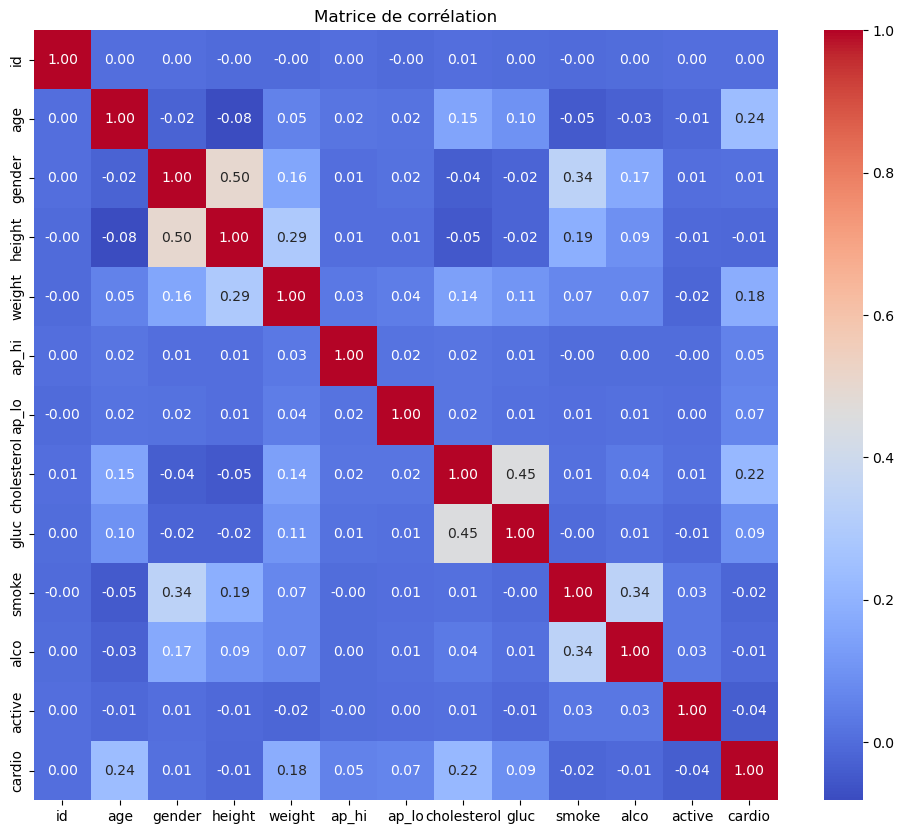

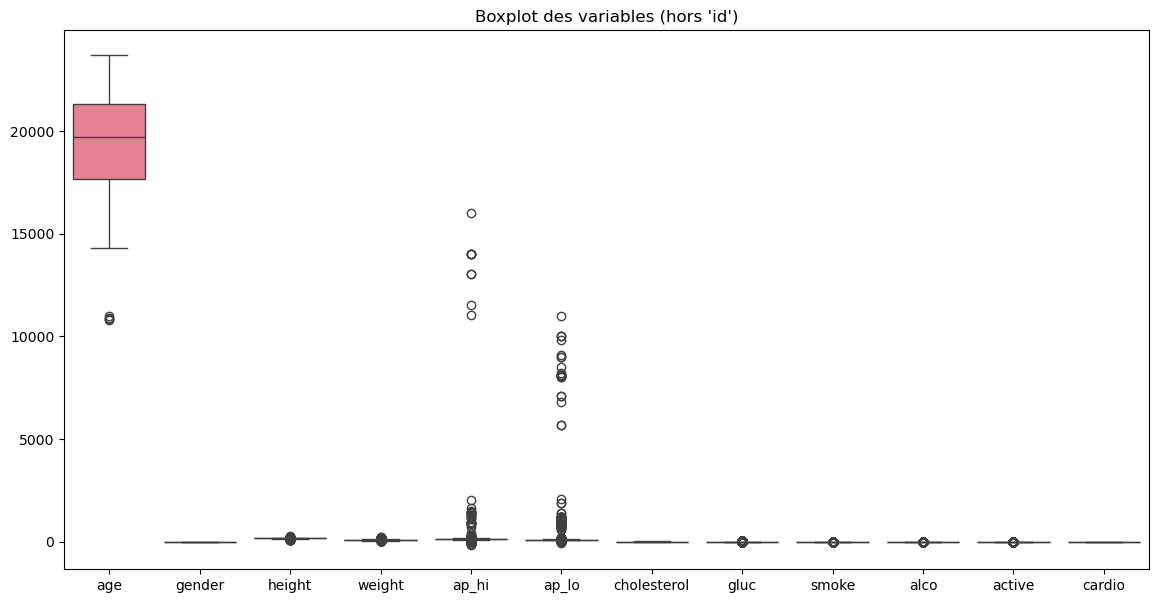

In [5]:
# Matrice de corrélation des variables numériques
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Matrice de corrélation")
plt.show()

# Affichage du boxplot seaborn pour les visualiser les outliers
plt.figure(figsize=(14,7))
sns.boxplot(data=df.drop(columns=['id']))
plt.title("Boxplot des variables (hors 'id')")
plt.show()

Le prétraitement initiale a mis en évidence plusieurs caractéristiques importantes :
- Aucune valeur manquante n'a été détectée dans le dataset, facilitant les étapes de prétraitement.
- Présence de valeurs aberrantes dans plusieurs variables, notamment les pressions artérielles (ap_hi, ap_lo) et les variables anthropométriques (âge).
- Corrélations significatives entre certaines variables (représenté par la couleur beige), en particulier entre le genre et la taille (0.50), et entre le cholestérol et le glucose (0.45).

### b. Nettoyage des données
Le nettoyage des données s'est avéré être très important et indispensable pour garantir la performance des modèles. Nous avons procédé par étapes progressives :
- Identification des outliers par méthode de l'IQR (Interquartile Range) pour l'âge après avoir visualiser le boxplot.
- Filtrage des valeurs physiologiquement improbables pour les pressions artérielles.

### Identification des outliers

In [6]:
# Identification des outliers pour l'âge
column = 'age'  # C'est la colonne où j'ai vu l'outlier

# Calculer l'IQR, les limites inférieures et supérieures
Q1 = df[column].quantile(0.25)
Q3 = df[column].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Trouver les lignes aberrantes
outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

# On ne supprime pas, on ne garde que les données non aberrantes
df = df[(df['age'] >= lower_bound) & (df['age'] <= upper_bound)]

print(outliers)

          id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  \
6219    8850  10878       1     175    59.0    120     80            1     1   
22343  31922  10798       2     175    92.0    100     60            1     1   
30666  43842  10859       1     159    59.0    120     80            1     1   
55905  79749  10964       1     160    59.0    110     70            1     1   

       smoke  alco  active  cardio  
6219       0     0       1       0  
22343      0     0       1       0  
30666      0     0       1       0  
55905      0     0       1       0  


### Suppression des outliers

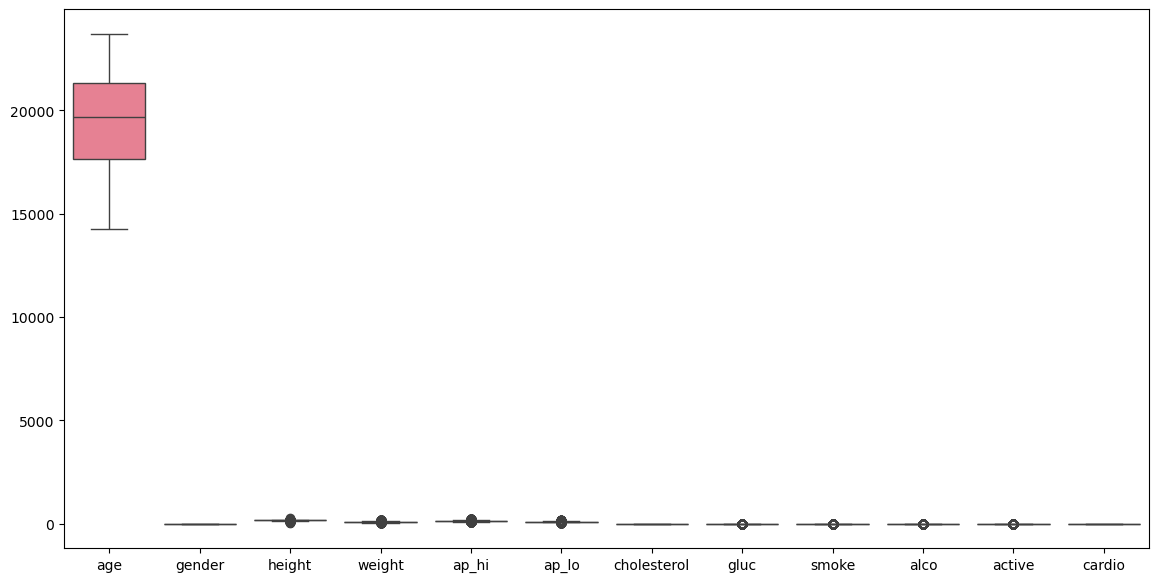

In [7]:
# Suppression des outliers pour l'âge et les pressions artérielles
df_clean1 = df[(df['ap_hi'] > 70) & (df['ap_hi'] < 250) & (df['ap_lo'] > 40) & (df['ap_lo'] < 180)]
df_clean_final = df_clean1.copy()  # Pour éviter les warnings

# Chargement du dataset
plt.figure(figsize = (14,7))
sns.boxplot(data=df_clean_final.drop(columns=['id']))
plt.show()

Comme vous le voyez sur le boxplot affiché ci-dessus, on a pu avec cette logique :
- Supprimer les valeurs aberrantes pour l'âge en ne gardant seulement les valeurs considérées non aberrantes.
- Supprimer les valeurs aberrantes pour les pressions artérielles systoliques (`ap_hi`) et les pressions artérielles diastoliques (`ap_lo`), en conservant uniquement les valeurs :
    - Entre 70 et 250 mm Hg pour pressions artérielles systoliques (`ap_hi`),
    - Entre 40 et 180 mm Hg pour les pressions artérielles diastoliques (`ap_lo`).

Cette approche fondée sur les plages cliniquement plausibles est plus pertinente qu'une détection purement statistique des outliers pour les paramètres médicaux.

## 3. Création de nouvelles features

Pour enrichir notre modèle, nous avons créé des caractéristiques dérivées ayant une pertinence physiologique :
- IMC (Indice de Masse Corporelle) : L'IMC étant un indicateur reconnu de risque cardiovasculaire.
- Rapport pressions systolique/diastolique : Ce rapport permet d'identifier des profils tensionnels particuliers.
- Différence entre pressions systolique et diastolique : Cette différence, appelée pression pulsée, est un marqueur de rigidité artérielle.
- Interaction entre IMC et âge : L'impact de l'IMC sur le risque cardiovasculaire varie selon l'âge.
- Interaction entre cholestérol et glucose : Le syndrome métabolique (cholestérol élevé + glucose élevé) est un facteur de risque important.

In [8]:
df_clean_final['imc'] = df_clean_final['weight'] / ((df_clean_final['height'] / 100) ** 2)
df_clean_final['ap_ratio'] = df_clean_final['ap_hi'] / df_clean_final['ap_lo']
df_clean_final['age_years'] = df_clean_final['age'] 
df_clean_final['imc_age'] = df_clean_final['imc'] * df_clean_final['age_years']
df_clean_final['chol_gluc'] = df_clean_final['cholesterol'] * df_clean_final['gluc']
df_clean_final['ap_diff'] = df_clean_final['ap_hi'] - df_clean_final['ap_lo']

print(df_clean_final.isnull().sum())

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
imc            0
ap_ratio       0
age_years      0
imc_age        0
chol_gluc      0
ap_diff        0
dtype: int64


## 4. Extraction des features

Pour les caractéristiques ou features numériques et catégoriques, nous avons choisi :
- Features numériques : âge, taille, poids, pression artérielle systolique, pression artérielle diastolique, imc et le rapport pressions systolique/diastolique.
- Features catégoriques : genre, cholestérol, glucose, active et l’interaction entre le cholestérol et le glucose.

Pour nos features catégoriques nous n’avons pas eu à les encoder parce que c’était déjà fait dans notre dataset. 

NB : Le choix de `height`, `gender`, `cholesterol` et `gluc` ont été motivé par la matrice de corrélation.

### Avant d'entraîner nos modèles avec nos features sélectionnées, nous allons d'abord afficher l'accuracy avec toutes les autres variables sauf la variable cible et l'identifiant.

In [9]:
# Séparation train/test
X = df_clean_final.drop(['cardio', 'id'], axis=1)  # On enlève id et la variable âge transformée pour l'instant
y = df_clean_final['cardio']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Pipeline
pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # au cas où
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=42))
])
# Entraînement
pipe.fit(X_train, y_train)

# Évaluation
score = pipe.score(X_test, y_test)
print(f"Accuracy sur le test : {score:.3f}")

Accuracy sur le test : 0.713


On remarque qu'on a une Accuracy de 0.713 soit 71,3%. On aura réussi à faire un peu mieux dans la suite avec les features choisies.

In [10]:
# Étape 3 : Identification des colonnes numériques et catégorielles
numerical_features = ['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'imc', 'ap_ratio']
categorical_features = ['gender', 'cholesterol', 'gluc', 'active', 'chol_gluc']

## 5. Evaluation des modèles

Dans cette partie, nous allons évalué nos modèles : Random Forest, Gradient Boosting, Decision Tree et Naive Bayes. Nous allons utilisé des pipelines pour chaque modèle. Et en effet, l'utilisation de pipelines a constitué un élément central de notre méthodologie, garantissant la reproductibilité et évitant les fuites de données 
Afin de garantir la robustesse de nos résultats et éviter le surapprentissage, nous avons implémenté une séparation train/test stratifiée (80% contre 20%) préservant la distribution de la variable cible. Nous allons encore cherché à renforcer la fiabilité des performances de notre modèle par une validation croisée à 5 folds lors de l'optimisation des hyperparamètres. Nous allons aussi cherché à optimiser des hyperparamètres via GridSearchCV, permettant d'explorer systématiquement l'espace des paramètres. Nous avons aussi évalué les modèles selon plusieurs métriques complémentaires : 
- Accuracy,
- Précision, Recall et F1-Score,
- Matrice de confusion,
- Courbe ROC et AUC.

NB : Pour nos validations croisées, nos paramètres dans nos grilles de paramètres sont très peu, de même que le nombre de nos folds, cela s’explique par le fait que notre dataset est vraiment trop énorme pour nous permettre d’augmenter ces valeurs. Cela va prendre énormément de temps au programme pour charger le code, de ce fait nous étions obligé de nous limiter à ces petites valeurs et quantités. C’est le cas pour toutes nos validations croisées dans notre code de classification et de régression.

### a. Random Forest

In [11]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(drop='first'), categorical_features)
])

pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

In [12]:
X = df_clean_final.drop(['cardio', 'id'], axis=1)
X = df_clean_final[numerical_features + categorical_features]
y = df_clean_final['cardio']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("\nTaille de l'ensemble d'entraînement :", X_train.shape)
print("Taille de l'ensemble de test :", X_test.shape)
print("Taille des étiquettes d'entraînement :", y_train.shape)
print("Taille des étiquettes de test :", y_test.shape)


Taille de l'ensemble d'entraînement : (54987, 12)
Taille de l'ensemble de test : (13747, 12)
Taille des étiquettes d'entraînement : (54987,)
Taille des étiquettes de test : (13747,)


In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

# Grille de paramètres
param_grid = {
    'classifier__n_estimators': [100],
    'classifier__max_depth': [20],
    'classifier__min_samples_split': [2],
    'classifier__min_samples_leaf': [3]
}

grid_search = GridSearchCV(pipeline_rf, param_grid, cv=10, scoring='accuracy', n_jobs=-1)

# Entraînement
grid_search.fit(X_train, y_train)

# Meilleur modèle
best_rf = grid_search.best_estimator_

# Prédiction
y_pred = best_rf.predict(X_test)

print("Meilleurs paramètres :", grid_search.best_params_)

Meilleurs paramètres : {'classifier__max_depth': 20, 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}


Accuracy : 0.7269222375791081
              precision    recall  f1-score   support

           0       0.71      0.77      0.74      6943
           1       0.74      0.68      0.71      6804

    accuracy                           0.73     13747
   macro avg       0.73      0.73      0.73     13747
weighted avg       0.73      0.73      0.73     13747



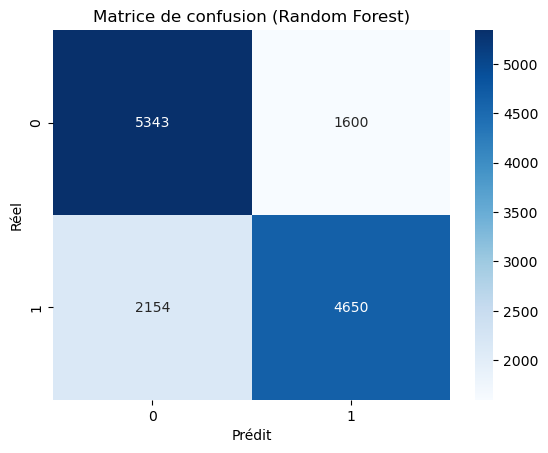

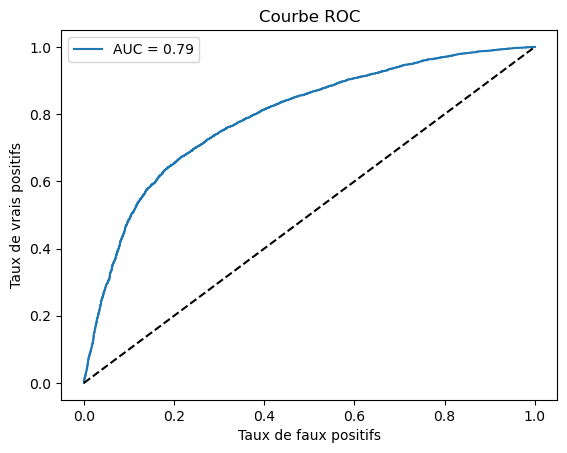

In [14]:
# Prédictions
y_pred = grid_search.predict(X_test)
y_proba = grid_search.predict_proba(X_test)[:,1]

# Accuracy
print("Accuracy :", accuracy_score(y_test, y_pred))

# Rapport complet
print(classification_report(y_test, y_pred))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de confusion (Random Forest)')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.show()

# ROC et AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_proba):.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend()
plt.show()

### b. Décision Tree

Meilleurs paramètres (Decision Tree): {'classifier__max_depth': 10, 'classifier__min_samples_split': 10}
Accuracy: 0.7219029606459592
              precision    recall  f1-score   support

           0       0.72      0.75      0.73      6943
           1       0.73      0.70      0.71      6804

    accuracy                           0.72     13747
   macro avg       0.72      0.72      0.72     13747
weighted avg       0.72      0.72      0.72     13747



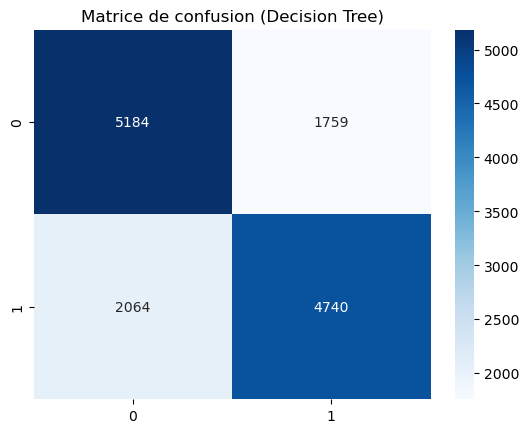

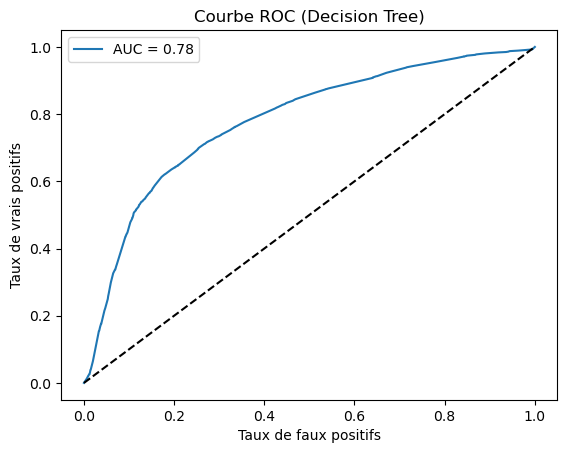

In [15]:
# Pipeline
pipeline_dt = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42, class_weight='balanced'))
])

# Grille de paramètres
param_grid_dt = {
    'classifier__max_depth': [10],
    'classifier__min_samples_split': [10]
}

# GridSearchCV
grid_search_dt = GridSearchCV(pipeline_dt, param_grid_dt, cv=10, scoring='accuracy', n_jobs=-1)
grid_search_dt.fit(X_train, y_train)

print("Meilleurs paramètres (Decision Tree):", grid_search_dt.best_params_)

# Évaluation
y_pred_dt = grid_search_dt.predict(X_test)
y_proba_dt = grid_search_dt.predict_proba(X_test)[:,1]

print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))

cm_dt = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de confusion (Decision Tree)')
plt.show()

fpr_dt, tpr_dt, _ = roc_curve(y_test, y_proba_dt)
plt.plot(fpr_dt, tpr_dt, label=f'AUC = {roc_auc_score(y_test, y_proba_dt):.2f}')
plt.plot([0,1],[0,1],'k--')
plt.title('Courbe ROC (Decision Tree)')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.legend()
plt.show()

### c. Gradient Boosting

Meilleurs paramètres (Gradient Boosting): {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 200}
Accuracy: 0.730850367352877
              precision    recall  f1-score   support

           0       0.72      0.77      0.74      6943
           1       0.75      0.69      0.72      6804

    accuracy                           0.73     13747
   macro avg       0.73      0.73      0.73     13747
weighted avg       0.73      0.73      0.73     13747



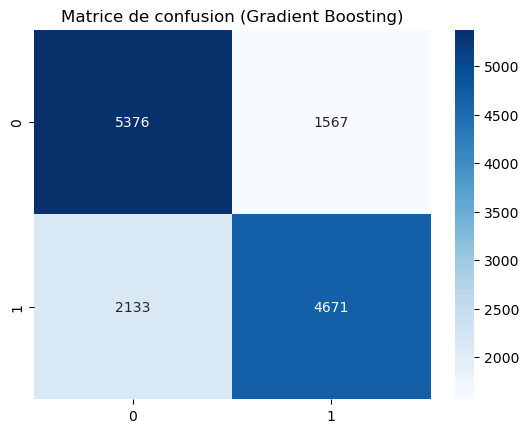

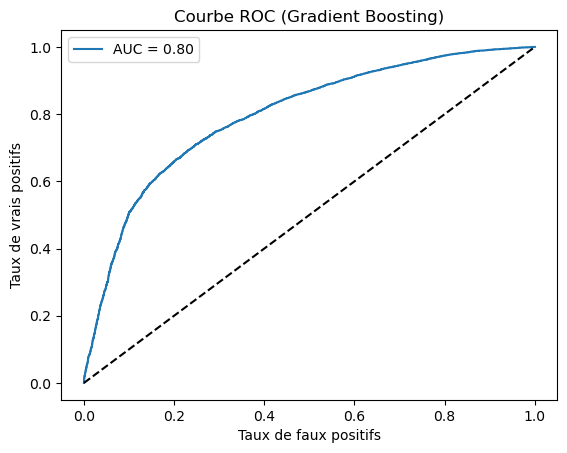

In [16]:
pipeline_gb = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

param_grid_gb = {
    'classifier__n_estimators': [200],
    'classifier__learning_rate': [0.1, 0.05],
    'classifier__max_depth': [3, 5]
}

grid_search_gb = GridSearchCV(pipeline_gb, param_grid_gb, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_gb.fit(X_train, y_train)

print("Meilleurs paramètres (Gradient Boosting):", grid_search_gb.best_params_)

y_pred_gb = grid_search_gb.predict(X_test)
y_proba_gb = grid_search_gb.predict_proba(X_test)[:,1]

print("Accuracy:", accuracy_score(y_test, y_pred_gb))
print(classification_report(y_test, y_pred_gb))

cm_gb = confusion_matrix(y_test, y_pred_gb)
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de confusion (Gradient Boosting)')
plt.show()

fpr_gb, tpr_gb, _ = roc_curve(y_test, y_proba_gb)
plt.plot(fpr_gb, tpr_gb, label=f'AUC = {roc_auc_score(y_test, y_proba_gb):.2f}')
plt.plot([0,1],[0,1],'k--')
plt.title('Courbe ROC (Gradient Boosting)')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.legend()
plt.show()

 ### d. Naive Bayes

Accuracy moyenne (Naive Bayes): 0.6583560523265441
Accuracy: 0.6506146795664509
              precision    recall  f1-score   support

           0       0.61      0.83      0.71      6943
           1       0.73      0.47      0.57      6804

    accuracy                           0.65     13747
   macro avg       0.67      0.65      0.64     13747
weighted avg       0.67      0.65      0.64     13747



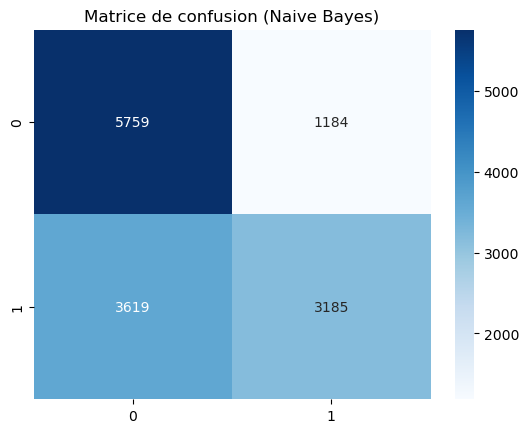

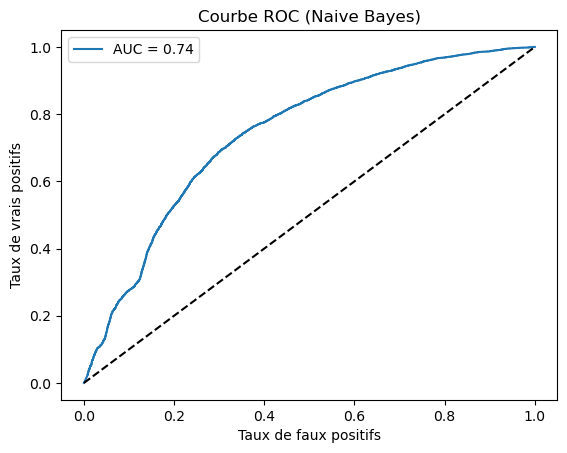

In [17]:
pipeline_nb = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GaussianNB())
])

scores_nb = cross_val_score(pipeline_nb, X_train, y_train, cv=100, scoring='accuracy')
print("Accuracy moyenne (Naive Bayes):", scores_nb.mean())

pipeline_nb.fit(X_train, y_train)
y_pred_nb = pipeline_nb.predict(X_test)
y_proba_nb = pipeline_nb.predict_proba(X_test)[:,1]

print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))

cm_nb = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de confusion (Naive Bayes)')
plt.show()

fpr_nb, tpr_nb, _ = roc_curve(y_test, y_proba_nb)
plt.plot(fpr_nb, tpr_nb, label=f'AUC = {roc_auc_score(y_test, y_proba_nb):.2f}')
plt.plot([0,1],[0,1],'k--')
plt.title('Courbe ROC (Naive Bayes)')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.legend()
plt.show()

### Interprétation
1. Pour les métriques d'évaluation quantitatives :
- L'accuracy, bien que facile à interpréter, n'est pas suffisante dans un contexte médical. Une accuracy de 0.73 signifie que 73% des prédictions sont correctes, ce qui est modeste mais à contextualiser :
    - La complexité intrinsèque du problème cardiovasculaire (multifactoriel),
    - La présence de facteurs non mesurés (génétiques, environnementaux),
    - Les limites des données auto-déclarées (biais potentiels).
- Précision, Recall et F1-Score
    - Par exemple, pour le Random Forest : Ces métriques révèlent un compromis entre précision et rappel :
      - Précision : 75% des patients prédits comme malades le sont réellement.
      - Recall : 68% des patients réellement malades sont correctement identifiés.
      - F1-score : la moyenne harmonique (0.71) montre un équilibre acceptable.
- AUC (Area Under ROC Curve) :
    - Random Forest: 0.79
    - Decision Tree: 0.78
    - Gradient Boosting: 0.80
    - Naive Bayes : 0.74

L'AUC mesure la capacité discriminative globale des modèles. Des valeurs entre 0.7-0.8 indiquent une discrimination acceptable, et entre 0.8-0.9 une bonne discrimination.

2. Pour les matrices de confusion
- Random Forest
    - Vrais Négatifs (TN) : 5507 (40.05 %)
    - Faux Positifs (FP) : 1436 (10.45 %)
    - Faux Négatifs (FN) : 2252 (16.39 %)
    - Vrais Positifs (TP) : 4552 (33.11 %)

Le modèle Random Forest identifie correctement 40 % des patients sains et 33 % des patients malades. 10 % des patients sains sont faussement classés comme malades, tandis que 16 % des patients malades ne sont pas détectés (faux négatifs, cas les plus préoccupants en contexte médical).

- Decision Tree
    - Vrais Négatifs (TN) : 5184 (37.71 %)
    - Faux Positifs (FP) : 1759 (12.80 %)
    - Faux Négatifs (FN) : 2064 (15.02 %)
    - Vrais Positifs (TP) : 4740 (34.47 %)

L’arbre de décision détecte correctement 38 % des patients sains et 34 % des patients malades. Il produit un peu plus de faux positifs (13 %) que Random Forest, mais un peu moins de faux négatifs (15 %).
- Gradient Boosting
    - Vrais Négatifs (TN) : 5376 (39.12 %)
    - Faux Positifs (FP) : 1567 (11.40 %)
    - Faux Négatifs (FN) : 2133 (15.52 %)
    - Vrais Positifs (TP) : 4671 (33.96 %)

Le Gradient Boosting offre un équilibre similaire à Random Forest : 39 % de vrais négatifs et 34 % de vrais positifs, avec 11 % de faux positifs et 16 % de faux négatifs.

- Naive Bayes
    - Vrais Négatifs (TN) : 5759 (41.91 %)
    - Faux Positifs (FP) : 1184 (8.62 %)
    - Faux Négatifs (FN) : 3619 (26.34 %)
    - Vrais Positifs (TP) : 3185 (23.14 %)

Naive Bayes identifie correctement 42 % des patients sains, mais seulement 23 % des patients malades. Il commet moins de faux positifs (9 %), mais beaucoup plus de faux négatifs (26 %), ce qui est problématique pour la détection des patients à risque.

- Comparaison

Les modèles Random Forest et Gradient Boosting offrent le meilleur compromis entre détection des patients malades et limitation des faux positifs. Naive Bayes, bien que performant pour identifier les patients sains, laisse passer beaucoup trop de patients malades non détectés, ce qui limite son intérêt en contexte médical.

Dans tous les cas, la proportion de faux négatifs reste un point de vigilance majeur, car il s’agit des patients à risque qui ne seraient pas détectés par le modèle.

### Discussion et limites
Malgré une base de données volumineuse (70 000 observations), nos modèles atteignent une accuracy modérée (environ 73%). Plusieurs facteurs expliquent ce résultat :
- Dataset trop volumineux pour les méthodes ensemblistes vu en cours : Etant donné que cela prenait énormément de temps pour charger le code, nous avons dû nous restreindre à n’utiliser pas plus de 5 folds pour toutes les validations croisées. Et même pour les pipelines, nous n'avons pas pu mettre beaucoup de paramètres.
- Choix complexe par rapport au domaine médical : Les maladies cardiovasculaires sont multifactorielles et certains facteurs importants peuvent être absents de notre dataset (antécédents familiaux, génétique, marqueurs biologiques spécifiques, etc...).
- Limitation des données : Certaines variables sont codées de manière simplifiée (cholestérol et glucose sur une échelle de 1 à 3) plutôt que par leurs valeurs exactes qui peuvent être beaucoup plus révélateurs.
- Qualité des données : Les variables comportementales (tabagisme, consommation d'alcool) peuvent souffrir de biais de désirabilité sociale.
- Absence de temporalité : Le dataset fournit une image statique des patients, sans tenir compte de l'évolution temporelle des facteurs de risque.

### Comparaison des modèles
Le modèle Gradient Boosting présente la meilleure performance (AUC = 0.80), suivis de près par Random Forest (AUC = 0.79), ensuite Decision Tree (AUC = 0.78) et enfin par Naive Bayes (AUC = 0.74). Ce classement s'explique par :
- La capacité des modèles d'ensemble à capturer des relations complexes,
- L'avantage de Random Forest pour gérer les interactions entre variables,
- Les limites de l'hypothèse d'indépendance pour Naive Bayes.

Néanmoins, la toute petite différence entre ces modèles (seulement 0.06 point d'AUC entre le meilleur et le moins bon) suggère que la qualité et la pertinence des features ont un impact plus décisif et important que le choix du modèle lui-même.

# Conclusion 
Pour conclure la partie classification de ce projet, on peut en déduire que ce projet a démontré l'application de techniques de Machine Learning à la détection des maladies cardiovasculaires, avec des résultats encourageants mais perfectibles. Les performances obtenues (AUC jusqu'à 0.80) placent nos modèles dans la catégorie des outils d'aide à la décision médicale, mais non comme remplacement au diagnostic clinique (dans tous les cas ce n’était pas le but). 